We will simulate the hole-doped Hubbard model on the square lattice with 16 sites and 12 electrons. This notebook should run in about 20mins on any standard GPU. 

We will use a HiddenPfaffian wavefunction Ansatz. The general form of the Ansatz is 

$ \ket{\psi} = \Big[ \sum_{i,j}^{n_e} \phi^{vv}_{ij} c^\dagger_i c^\dagger_j + \Big(\sum_{i,l}^{n_e, n_h} \phi^{vh}_{i l } (\{ n \} )   c^\dagger_i d^\dagger_l + \textrm{h.c.} \Big)  + \sum_{k,l}^{n_h} \phi^{hh}_{k l} (\{ n \} )  d^\dagger_k d^\dagger_l    \Big]^{(n_e + n_h) / 2} $

where $c^\dagger$ and $d^\dagger$ are hidden and visible fermions respectively. The hidden fermions orbitals are always occupied, so the projection onto a basis state is given by

$ \bra{ \{n \}} | \ket{\psi} = \bra{0} \prod_{n \in \{n \}}  c_n \prod_k^{n_h} d_k \ket{\psi} $

This can be computed as a pfaffian.

$\bra{ \{n \}} | \ket{\psi} = \textrm{pf} (( n * \phi^{v v} * n , n * \phi^{v h}), (  -(n * \phi^{v h} )^T,  \phi^{h h} )) $

where $n * v$ indicates that the vector is sliced along the occupied components. We begin by defining the Hamiltonian and lattice. These are global variables, once they are defined, they are used throughout the rest of the calculation.    

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp
import equinox as eqx
import quantax as qtx
from quantax.symmetry import Identity, Trans2D, C4v, SpinInverse
from IPython.display import clear_output
%config InlineBackend.figure_format = 'svg'

qtx.set_default_dtype(jnp.float64)
L = 4

#4 x 4 square lattice 1/8 doping
lattice = qtx.sites.Square(L, is_fermion=True, Nparticle=(6,6))
N = lattice.N
Nparticle = lattice.Nparticle
layers = 4 
Nhid = 4

hamiltonian = qtx.operator.Hubbard(U=8)



/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sites/sites.py:32: UserWarning: A second 'sites' is defined.
  warn("A second 'sites' is defined.")


First we will train a mean field Pfaffian wavefunction. This may be used as an initialization for our HiddenPfaffian. Our full pfaffian can be written as the pfaffian of a block matrix.

$\bra{ \{n \}} | \ket{\psi} = \textrm{pf} (( \phi_{v v},  \phi_{v h}), (  -\phi_{v h}^T,  \phi_{h h} )) $

During this part, we are just training a mean field pfaffian $\textrm{pf} (\phi_{v v})$

The "sublattice" variable describes how we allow our mean field wavefucntion to break symmetry. This is the effective unit cell size of the mean field order. For example if we have an anti-ferromagnet we can start from a 2x2 unit cell. For our purposes we will not impose sublattice symmetry in order to be as flexible as possible

In [5]:
#Choose the unit cell of the mean field wavefunction
sublattice = (4,4)

#Mean field wavefunction is pfaffian with a 2x2 unit cell
mf = qtx.model.Pfaffian(dtype=jnp.float64, sublattice=sublattice)

state = qtx.state.Variational(mf,max_parallel=32768)

sampler = qtx.sampler.NeighborExchange(state,1000)
tdvp = qtx.optimizer.TDVP(state,hamiltonian,solver=qtx.optimizer.auto_pinv_eig(rtol=1e-6))

energy_data = qtx.utils.DataTracer()
variance_data = qtx.utils.DataTracer()
for i in range(300):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step*0.01)
    energy_data.append(tdvp.energy)
    variance_data.append(tdvp.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        variance_data.plot()
        plt.show()



/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:38: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:245: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:333: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/state/variational.py:530: SyntaxWarning: invalid escape sequence '\l'
  """


KeyboardInterrupt: 

Now we take a look spin-spin $<s^z_i s^z_j>$ and charge-charge $<n_i n_j>$ correlations for our mean field orbitals. Typically the symmetry of these orbitals will have the symmetry of the sublattice parameter. If we are looking     

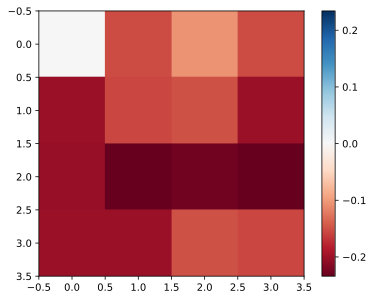

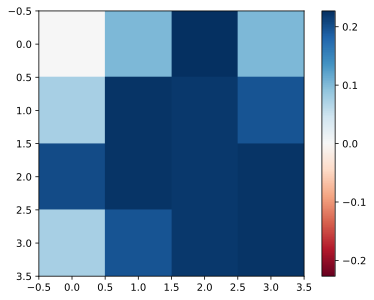

In [4]:
#look at <s^z_i s^z_j> and <n_i n_j> for cnn

samps = samples.spins
spins = samps[:,:N] - samps[:,N:]
spins = spins.reshape(-1,L,L)
charge = samps[:,:N] + samps[:,N:]
charge = charge.reshape(-1,L,L)

charge_charge = jnp.zeros([L,L])
spin_spin = jnp.zeros([L,L])
for i in range(L):
    for j in range(L):
        corr_spin = jnp.mean(spins*jnp.roll(spins,(i,j),axis=(-2,-1)))
        corr_charge = jnp.mean(charge*jnp.roll(charge,(i,j),axis=(-2,-1)))

        spin_spin = spin_spin.at[i,j].set(corr_spin)       
        charge_charge = charge_charge.at[i,j].set(corr_charge)       

spin_spin = spin_spin.at[0,0].set(0)
charge_charge = charge_charge.at[0,0].set(0)

maxval = jnp.amax(jnp.abs(spin_spin))
plt.imshow(spin_spin, cmap='RdBu', vmin=-1*maxval,vmax=maxval)
plt.colorbar()
plt.show()
maxval = jnp.amax(jnp.abs(charge_charge))
plt.imshow(charge_charge, cmap='RdBu', vmin=-1*maxval,vmax=maxval)
plt.colorbar()



Now we will train the CNN which parametrizes both $\phi_hv (\{ n \})$ and $\phi_nn (\{ n \})$. The CNN is given as an argument to the HiddenPfaffian module   

In [6]:
#CNN network is used to output the configuration dependent hidden-visible and hidden-hidden pairings
net = qtx.model.ResSum(layers,4*Nhid,3,final_activation=lambda x: x, trans_symm=Identity(), dtype=jnp.float64)
model = qtx.model.HiddenPfaffian(pairing_net = net, dtype=jnp.float64, sublattice=sublattice, trans_symm = Trans2D())

If we think our mean field more-or-less gets the correlations correct, we can load it into the CNN using this block. Otherwise, it might be better to train the HiddenPfaffian from scratch. Right now we are still unclear on which training strategy is better. The block below loads the parameters of the mean field into the Hidden Pfaffian. 

In [ ]:
state.save("/tmp/model.eqx")
F = eqx.tree_deserialise_leaves("/tmp/model.eqx",model.layers[-1].F)
model = eqx.tree_at(lambda tree: tree.layers[-1].F, model, F)

Now we define the new variational state and optimizer. When inverting the neural tangent kernel for MinSR we have lowered the minimum eigenvalue. This is because the CNN smooths out the training landscape and we can take larger step sizes. 

In [7]:
state = qtx.state.Variational(model,max_parallel=32768)
sampler = qtx.sampler.NeighborExchange(state,1000)
tdvp = qtx.optimizer.TDVP(state,hamiltonian,solver=qtx.optimizer.auto_pinv_eig(rtol=1e-12))


KeyboardInterrupt: 

Now we run the CNN again. 

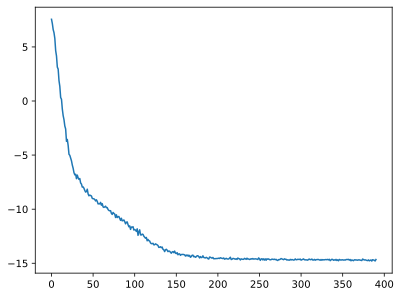

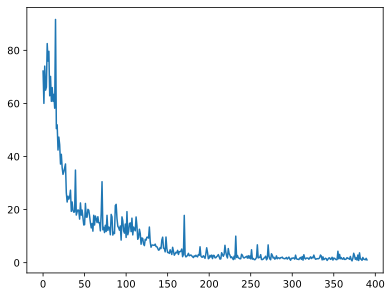

/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:38: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:245: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:333: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/state/variational.py:530: SyntaxWarning: invalid escape sequence '\l'
  """


KeyboardInterrupt: 

In [8]:
energy_data = qtx.utils.DataTracer()
variance_data = qtx.utils.DataTracer()
for i in range(500):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step*0.01)
    energy_data.append(tdvp.energy)
    variance_data.append(tdvp.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        variance_data.plot()
        plt.show()

We can look at the correlation functions for the CNN and see if they have changed from the mean field. If they have, we might want to iterate on the mean field to choose a better starting point. We can always add a pinning field to bias the mean field in a certain direction

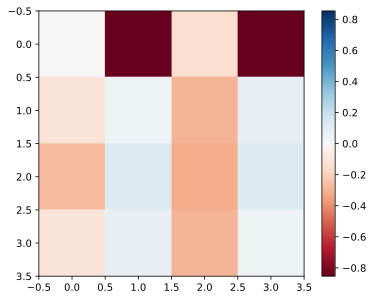

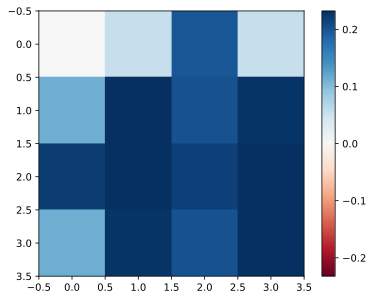

In [9]:
#look at <s^z_i s^z_j> and <n_i n_j> for cnn

samps = samples.spins
spins = samps[:,:N] - samps[:,N:]
spins = spins.reshape(-1,L,L)
charge = samps[:,:N] + samps[:,N:]
charge = charge.reshape(-1,L,L)

charge_charge = jnp.zeros([L,L])
spin_spin = jnp.zeros([L,L])
for i in range(L):
    for j in range(L):
        corr_spin = jnp.mean(spins*jnp.roll(spins,(i,j),axis=(-2,-1)))
        corr_charge = jnp.mean(charge*jnp.roll(charge,(i,j),axis=(-2,-1)))

        spin_spin = spin_spin.at[i,j].set(corr_spin)       
        charge_charge = charge_charge.at[i,j].set(corr_charge)       

spin_spin = spin_spin.at[0,0].set(0)
charge_charge = charge_charge.at[0,0].set(0)

maxval = jnp.amax(jnp.abs(spin_spin))
plt.imshow(spin_spin, cmap='RdBu', vmin=-1*maxval,vmax=maxval)
plt.colorbar()
plt.show()
maxval = jnp.amax(jnp.abs(charge_charge))
plt.imshow(charge_charge, cmap='RdBu', vmin=-1*maxval,vmax=maxval)
plt.colorbar()


When all is said and done, we can get the best possible variational energies by symmetrizing over the point group. We can do this by adding symmetries to the variational state. 

In [10]:
state.save("/tmp/model.eqx")
model = qtx.model.HiddenPfaffian(pairing_net = net, dtype=jnp.float64, sublattice=sublattice, trans_symm = Trans2D())

state = qtx.state.Variational(model,symm=SpinInverse() + C4v(),max_parallel=8192, param_file="/tmp/model.eqx")

sampler = qtx.sampler.NeighborExchange(state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(state,hamiltonian,solver=qtx.optimizer.auto_pinv_eig(rtol=1e-12))


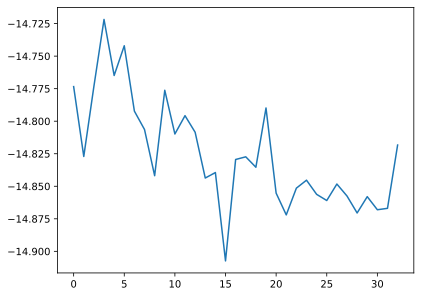

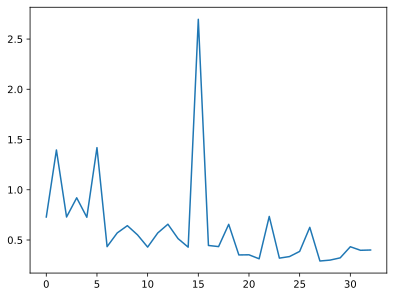

KeyboardInterrupt: 

In [11]:
energy_data = qtx.utils.DataTracer()
variance_data = qtx.utils.DataTracer()
for i in range(100):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step*0.01)
    energy_data.append(tdvp.energy)
    variance_data.append(tdvp.VarE)

    clear_output()
    energy_data.plot()
    plt.show()
    variance_data.plot()
    plt.show()

Here's a bit of code for diagonalizing the Hamiltonian exactly. These symmetries specify a set of quantum numbers for different symmetries. Here we are choosing the sector which is invariant over all symmetries. 

In [13]:
symm = SpinInverse() + C4v() + Trans2D()
E, wf = hamiltonian.diagonalize(symm)
print(E)

/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/symmetry/symmetry.py:261: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  self.basis.make()


[-14.92531022]
